In [419]:
#imports
import tensorflow as tf
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
import util
import pickle
from random import randrange
import scipy
import math

In [506]:
#generate random chord with 1-6 notes
maxNotes = 6
noise_power = 70 #add white noise

#22 = G2, 53 = D5    D5 freq = 587, G2 freq = 98   (limit freqs?)
lower = 22
upper = 53

#generate numcols random columns from a spectrogram, return (col(s), freqInterval, ans[])
def gencols(numcols):
    cols = []
    
    #pick a random number of notes
    numNotes = randrange(maxNotes) + 1
    # numNotes = 7
    notes = []
    
    #generate notes
    for i in range(numNotes):
        rand = randrange(upper - lower + 1) + lower
        while rand in notes:
            rand = randrange(upper - lower + 1) + lower
        notes.append(rand)
    
    #compile sounds
    sound = AudioSegment.from_file("pianomonoindexed/" + str(notes[0]) + ".mp3", format="mp3")
    for i in range(1, numNotes):
        soundnew = AudioSegment.from_file("pianomonoindexed/" + str(notes[i]) + ".mp3", format="mp3")
        #add a randomized decibel offset between -10 and 5
        offset = randrange(15) - 10
        soundnew += offset
        sound = sound.overlay(soundnew, position=0)

    data = np.array(sound.get_array_of_samples())
    noise = np.int_(np.round(np.random.normal(scale=100, size=len(data))))
    data += noise
    
    #generate spectrum
    #plt.specgram for visual spectrum (uses more time)
    #spectrum, freqs, times, dot = plt.specgram(np.array(sound.get_array_of_samples()), Fs=sound.frame_rate, NFFT=8192)
    #plt.show()
    #scipy.signal.spectrogram for without visual graph (save time)
    freqs, times, spectrum = scipy.signal.spectrogram(np.array(sound.get_array_of_samples()), fs=sound.frame_rate, nperseg=8192)
    #with the current settings, spectrum = [4097, 2] (dimensions)
    
    #generate the answer array
    ans = []
    for i in range(upper - lower + 1):
        if (i + lower) in notes:
            ans.append(1)
        else:
            ans.append(0)
    
    if numcols == 1:
        randbool = randrange(1)
        return ([spectrum[:,randbool]], freqs[1], ans)
    else:
        return (np.transpose(spectrum), freqs[1], ans)

In [421]:
print(gencols(1))

([array([2.8098168e+00, 2.5513484e+02, 3.3944241e+02, ..., 2.1308322e-05,
       3.4152519e-05, 3.4462199e-05], dtype=float32)], 5.38330078125, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0])


0 train
0 test
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


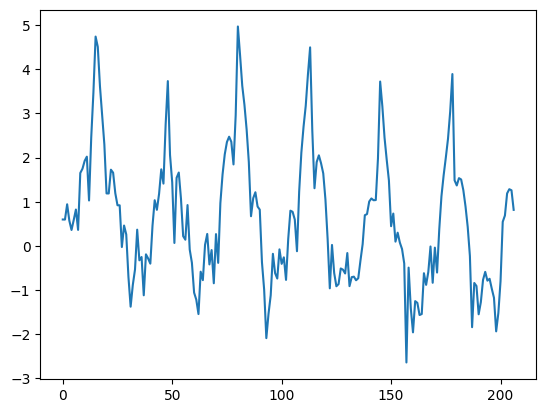

In [422]:
#create and serialize data
xtrain = []
ytrain = []
xtest = []
ytest = []

#data will have 1-6 note chords, only containing notes from G2 to D5 (inclusive)
numtrain = 1
numtest = 1

minfreq = 95
maxfreq = 1200
numcolsPerSample = 1


def normalize(arr):
    ##TODO LOGARIZE + NORMALIZE DATA
    return np.log10(arr)



for i in range(math.ceil(numtrain/numcolsPerSample)):
    columns, basefreq, ans = gencols(numcolsPerSample)
    for col in columns:
        #trim the desired frequncies
        lowerindex = math.floor(minfreq/basefreq)
        upperindex = math.ceil(maxfreq/basefreq)
        xtrain.append(normalize(col[lowerindex:upperindex + 1]))
    ytrain.append(ans)
    print(str(i) + " train")
    
for i in range(math.ceil(numtest/numcolsPerSample)):
    columns, basefreq, ans = gencols(numcolsPerSample)
    for col in columns:
        #trim the desired frequncies
        lowerindex = math.floor(minfreq/basefreq)
        upperindex = math.ceil(maxfreq/basefreq)
        xtest.append(normalize(col[lowerindex:upperindex + 1]))
    ytest.append(ans)
    print(str(i) + " test")

    
folder = "trainingdata/"
pickle.dump(xtrain, open(folder + "xtrain.p", "wb"))
plt.plot(xtrain[0])
print(ytrain[0])


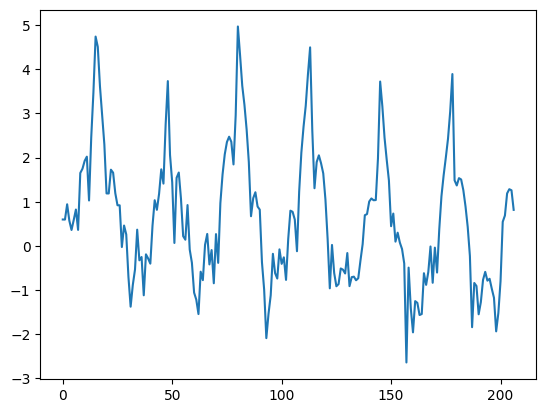

In [423]:
data = pickle.load(open(folder + "xtrain.p", "rb"))
plt.plot(data[0])

In [424]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

In [425]:
train_size = 1
x_train = []
y_train = []
for i in range(train_size):
  columns, basefreq, ans = gencols(1)
  x_train.append(columns[0])
  y_train.append(ans)

In [426]:
# train2_size = 1000

# x_train2 = []
# y_train2 = []
# for i in range(train2_size):
#   columns, basefreq, ans = gencols(1)
#   x_train2.append(columns[0])
#   y_train2.append(ans)
# x_train2 = np.array(x_train2)
# y_train2 = np.array(y_train2)
# batch_size2 = 10
# ds2 = TensorDataset(torch.Tensor(x_train2), torch.Tensor(y_train2))
# train2_dl = DataLoader(ds2, batch_size=batch_size2, shuffle=True)

In [427]:
x_train = np.array(x_train)
y_train = np.array(y_train)

in_size = x_train.shape[1]
out_size = y_train.shape[1]

In [428]:
batch_size = 100
# ds = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
# train_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)
# torch.save(ds, 'ds4.pt')
ds = torch.load('ds4.pt')
train_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [429]:
# test_size = 100000
# x_test = []
# y_test = []
# for i in range(test_size):
#   columns, basefreq, ans = gencols(1)
#   x_test.append(columns[0])
#   y_test.append(ans)
# x_test = np.array(x_test)
# y_test = np.array(y_test)
# test_ds = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
# torch.save(test_ds, 'ds5.pt')

KeyboardInterrupt: 

In [ ]:
# ds = torch.load('ds5.pt')
# train_dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [04:17<00:00,  2.57s/it]

0.0035993362311273814


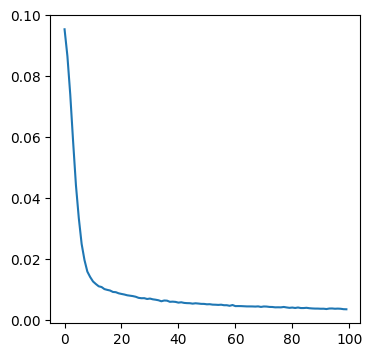

In [431]:
lr = 0.05
ep = 100
net = nn.Sequential(
  nn.Sigmoid(),
  nn.Linear(in_size, 400),
  nn.ReLU(),
  nn.Linear(400, 400),
  nn.ReLU(),
  nn.Linear(400, out_size)
)

loss_fcn = nn.MSELoss()
optim = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
losses = []

losses = []
for epoch in tqdm(range(ep)):
  total_items = 0
  total_loss = 0
  for x,t in train_dl:
    y = net.forward(x)
    loss = loss_fcn(y, t)
    total_loss += loss.item() * len(x)
    total_items += len(x)
    optim.zero_grad()
    loss.backward()
    optim.step()
  losses.append(total_loss / total_items)
plt.figure(figsize=(4,4))
plt.plot(losses)
print(losses[-1])

In [484]:
test_size = 100
x_test = []
y_test = []
for i in range(test_size):
  columns, basefreq, ans = gencols(1)
  x_test.append(columns[0])
  y_test.append(ans)
x_test = np.array(x_test)
y_test = np.array(y_test)
test_ds = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
torch.save(test_ds, 'ds27.pt')


In [509]:
test_ds = torch.load('ds3.pt')
test_dl = DataLoader(test_ds, batch_size=test_size, shuffle=True)

In [510]:
correct = 0
stats = [[0] * 4 for _ in range(7)] # num_samples, perfects, missed, false positives
x,t = next(iter(test_dl))
y = net.forward(x)
yy, tt = y[0],  t[0]
for i in range(len(y)):
  yy, tt = torch.abs(torch.round(y[i] + 0.16)), t[i]
  note_count = (tt == 1.).sum().item() - 1
  row = stats[note_count]
  miss, fpos = 0, 0
  for i in range(32):
    if yy[i] < tt[i]: miss += 1
    elif yy[i] > tt[i]: fpos += 1
  row[0] += 1
  row[1] += (miss + fpos == 0)
  row[2] += miss
  row[3] += fpos
for row in stats:
  for i in range(1, 4):
    if row[0] > 0:
      row[i] = round(row[i] / row[0], 3)
  print(row)

[13, 1.0, 0.0, 0.0]
[16, 1.0, 0.0, 0.0]
[17, 1.0, 0.0, 0.0]
[15, 1.0, 0.0, 0.0]
[16, 1.0, 0.0, 0.0]
[23, 0.957, 0.043, 0.0]
[0, 0, 0, 0]


In [ ]:
a = torch.abs(torch.round(yy))
(a == 0.).sum().item()

30

In [ ]:
correct = 0
for _ in range(100):
  x,t = next(iter(test_dl))
  y = net.forward(x)
  for i in range(len(y)):
    if t[i][torch.argmax(y[i])] == 1:
      correct += 1
print(correct)

998


In [ ]:
total_items = 0
total_loss = 0
for x,t in test_dl:
  y = net.forward(x)
  print(y[0], t[0])
  loss = loss_fcn(y, t)
  total_loss += loss.item() * len(x)
  total_items += len(x)
print(total_loss / total_items)

tensor([ 2.1035e-01,  2.5535e-02,  1.3648e-01,  4.0203e-04,  8.3283e-02,
         1.6276e-01,  1.0395e-01,  1.7955e-01,  1.5995e-01, -2.2851e-02,
        -4.9671e-02,  9.4164e-02,  7.8882e-02, -9.0042e-04, -4.4796e-03,
        -8.1713e-03,  1.6078e-01, -3.4422e-02, -4.1060e-02, -8.1070e-02,
        -3.8828e-02,  1.3669e-01,  6.2870e-01,  5.5628e-02,  2.0356e-02,
         1.5094e-01,  8.4362e-02,  1.5942e-01,  2.3391e-01,  1.5452e-01,
         2.0720e-02,  2.9662e-01], grad_fn=<SelectBackward>) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 8.0939e-02, -1.2961e-02,  5.9533e-02,  2.9182e-02,  5.3720e-02,
         1.2098e-01,  5.7137e-02,  1.5804e-01,  1.0308e-01, -5.3927e-02,
         1.3712e-01,  9.6873e-02,  4.8563e-02, -9.9659e-02,  5.8924e-02,
         9.6598e-02,  2.5072e-01,  2.7414e-02,  4.4467e-02,  8.4426e-01,
         2.3124e-01,  7.3522e-02, -6.7129e-02,  2.0277e-02,  6.8